In [1]:
import sys
assert sys.version_info >= (3, 5)

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import pandas as pd

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



In [2]:
train_df = pd.read_csv('/home/polina/IdeaProjects/Intelligent-Systems/Task6/sign_mnist_test.csv')
test_df = pd.read_csv('/home/polina/IdeaProjects/Intelligent-Systems/Task6/sign_mnist_test.csv')
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [3]:
train_data = np.asarray(train_df,dtype=np.int32)
test_data = np.asarray(test_df,dtype=np.int32)
x_train = train_data[:,1:]
y_train = train_data[:,0]
x_test = test_data[:,1:]
y_test = test_data[:,0]

In [4]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=.25,random_state=42)

In [5]:
def plot_signs(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

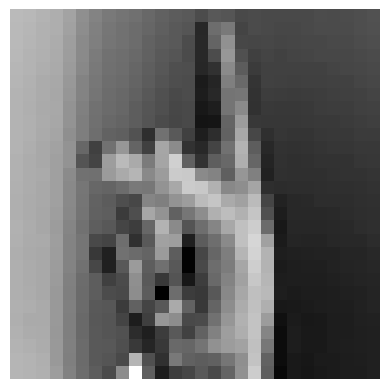

In [6]:
plot_signs(x_train[1])


In [7]:
def plot_language_signs(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))
    big_image = image_grid.transpose(0, 2, 1,3).reshape(n_rows * size,images_per_row * size)
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

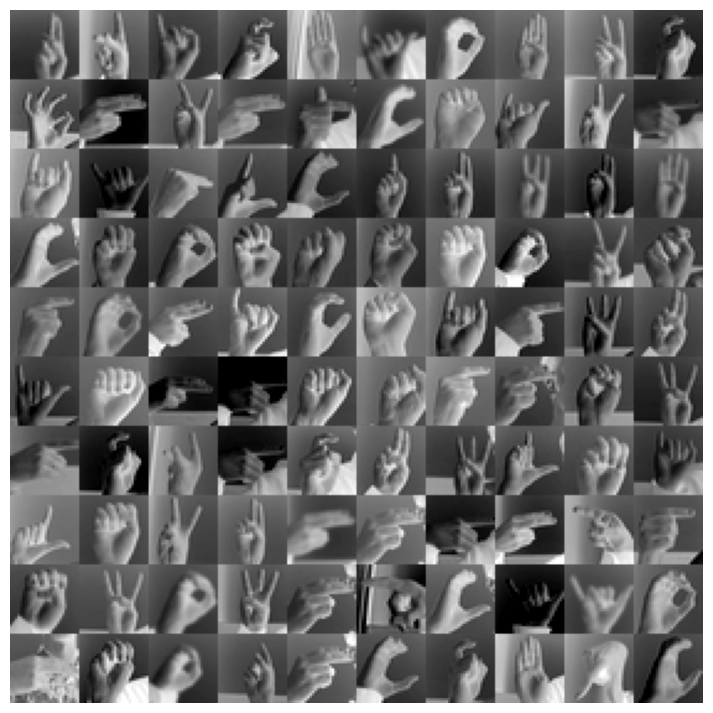

In [8]:
plt.figure(figsize=(9,9))
example_images = x_train[:100]
plot_language_signs(example_images, images_per_row=10)
plt.show()

In [9]:
y_train = y_train.astype(np.uint8)
y_train

array([20, 10,  8, ...,  7, 24,  6], dtype=uint8)

In [10]:
y_train_sign = (y_train == 1)
y_test_sign = (y_test == 1)

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(x_train, y_train_sign)
some_signs = x_train[7]
sgd_clf.predict([some_signs])

array([ True])

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train_sign, cv=3, scoring="accuracy")

array([0.99832683, 0.99832683, 0.99721138])

## Performance Measures
#### Measuring Accuracy Using Cross-Validation

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.base import BaseEstimator #in43
from sklearn.model_selection import cross_val_predict #in44
from sklearn.metrics import confusion_matrix #in44


In [14]:
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(x_train, y_train_sign):
    clone_clf = clone(sgd_clf)
    X_train_folds = x_train[train_index]
    y_train_folds = y_train_sign[train_index]
    X_test_fold = x_train[test_index]
    y_test_fold = y_train_sign[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9988845510317903
0.9994422755158952
0.9994422755158952


In [15]:
class NeverSignClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_sign_clf = NeverSignClassifier()
cross_val_score(never_sign_clf, x_train, y_train_sign, cv=3, scoring="accuracy")

array([0.94645845, 0.93920803, 0.9431121 ])

In [16]:

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_sign, cv=3)
confusion_matrix(y_train_sign, y_train_pred)

array([[5068,    4],
       [   7,  300]])

In [17]:
y_train_perfect_predictions = y_train_sign  # pretend we reached perfection
confusion_matrix(y_train_sign, y_train_perfect_predictions)

array([[5072,    0],
       [   0,  307]])

### Precision and Recall


In [18]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
precision_score(y_train_sign, y_train_pred)

0.9868421052631579

In [19]:
cm = confusion_matrix(y_train_sign, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.9868421052631579

In [20]:
recall_score(y_train_sign, y_train_pred)

0.9771986970684039

In [21]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.9771986970684039

In [22]:
f1_score(y_train_sign, y_train_pred)

0.9819967266775776

In [23]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.9819967266775778

### Precision/Recall Trade-off

In [24]:
y_scores = sgd_clf.decision_function([some_signs])
y_scores

array([753491.46861493])

In [25]:
threshold = 0
y_some_signs_pred = (y_scores > threshold)
y_some_signs_pred


array([ True])

In [26]:
threshold = 8000
y_some_signs_pred = (y_scores > threshold)
y_some_signs_pred


array([ True])

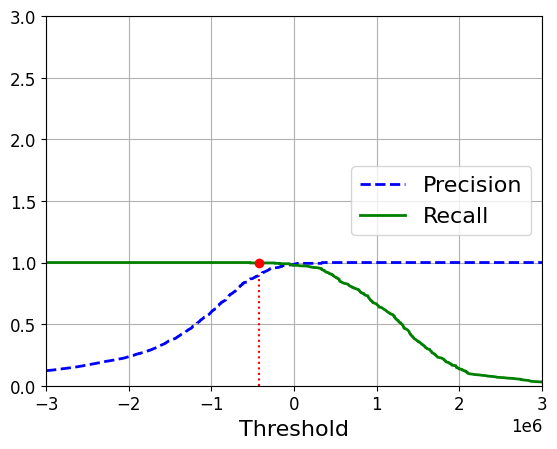

In [27]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_sign, cv=3,  method="decision_function")
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_sign, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-3000000, 3000000, 0, 3])

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()
#Точність та повнота в порівнянні з порогом прийняття рішення

In [28]:
(y_train_pred == (y_scores > 0)).all()

True

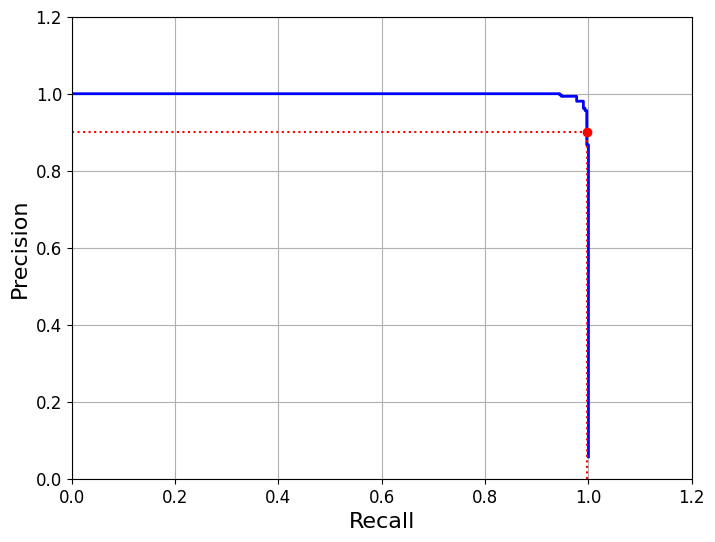

In [29]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1.2, 0, 1.2])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()
#Точність у порівнянні з повнотою

In [30]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

-425537.59258400643

In [31]:

#Точність класифікатора
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_sign, y_train_pred_90)

0.9

In [32]:
recall_score(y_train_sign, y_train_pred_90)


0.996742671009772

### The ROC Curve

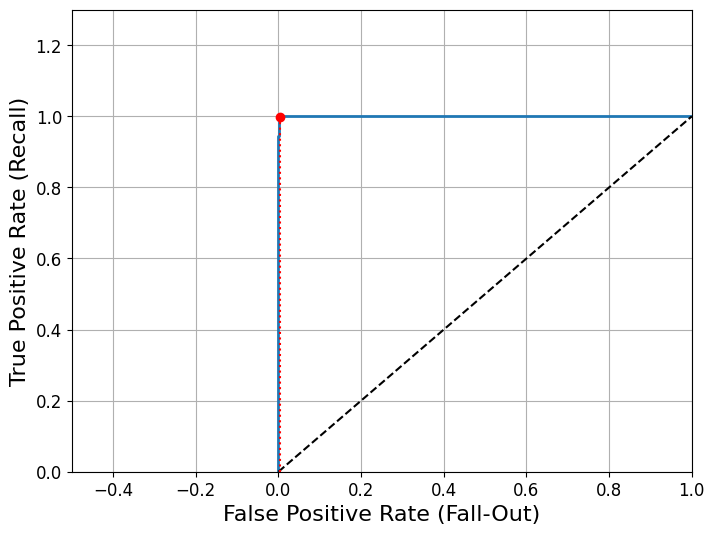

In [33]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_sign, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.5, 1, 0,1.3])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()
#Крива ROC

In [34]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_sign, y_scores)

0.9999255027281415

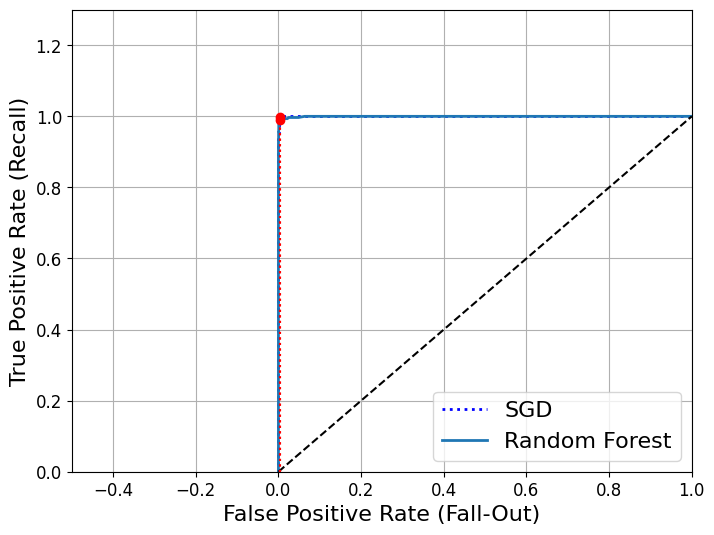

In [35]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_sign, cv=3,
                                    method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_sign,y_scores_forest)
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()
#Порівняння кривих ROC

In [36]:
y_train_pred_forest = cross_val_predict(forest_clf, x_train, y_train_sign, cv=3)
precision_score(y_train_sign, y_train_pred_forest)

1.0

In [37]:
recall_score(y_train_sign, y_train_pred_forest)

0.8469055374592834

### Multiclass Classification

In [38]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(x_train[:1000], y_train[:1000]) # y_train, not y_train_trouser
svm_clf.predict([some_signs])
some_signs_scores = svm_clf.decision_function([some_signs])
some_signs_scores

array([[ 9.92380003, 23.31944411, 19.2832486 ,  5.73949269, 20.29519894,
         2.7151687 , 15.19290413, 22.29655432,  8.82449326, 11.01416429,
         1.6994878 , 21.29528837, 14.16573283,  7.77227006, 17.23769402,
         0.69307812, -0.31370777,  3.72006453,  4.72526354, 12.05036137,
        16.22514969,  6.74689973, 13.16534349, 18.23824317]])

In [39]:
svm_clf.classes_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=uint8)

In [40]:
np.argmax(some_signs_scores)

1

In [41]:
from sklearn.multiclass import OneVsRestClassifier
#Багатокласовий класифікатор
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(x_train[:1000], y_train[:1000])
ovr_clf.predict([some_signs])

array([1], dtype=uint8)

In [42]:
len(ovr_clf.estimators_)

24

In [43]:
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([some_signs])

array([1], dtype=uint8)

In [44]:
sgd_clf.decision_function([some_signs])

array([[-2061543.0883543 ,  1108015.6275621 , -1899088.59788404,
        -1294698.93043417, -1630192.41748545, -1027569.77804529,
        -1769255.26289656, -2334852.19412969, -1816086.64229061,
        -2666742.94985584, -3464257.34351862,  -911556.88113312,
        -1074894.13988127, -1327713.28590843, -3916235.83454926,
        -3911334.52190575, -1006006.18101097, -1056321.93334289,
        -2446579.96934307,  -230120.23408369, -2478615.21425098,
         -948564.90402531, -1328526.94622616, -2115123.71101315]])

In [45]:
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.99832683, 0.9431121 , 0.98884551])

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.99832683, 0.99721138, 0.99665365])

### Error Analysis

In [47]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[247,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 307,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 244,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 181,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 374,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 184,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 274,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0

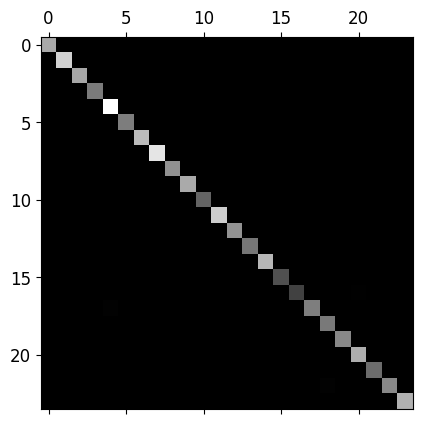

In [48]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

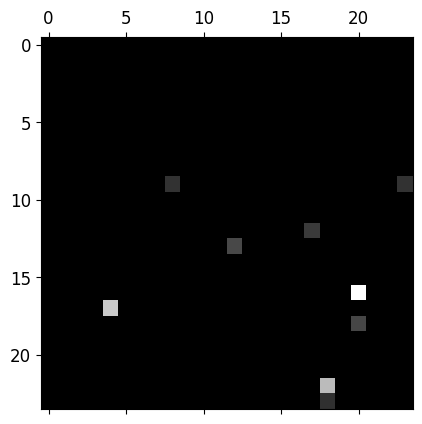

In [49]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

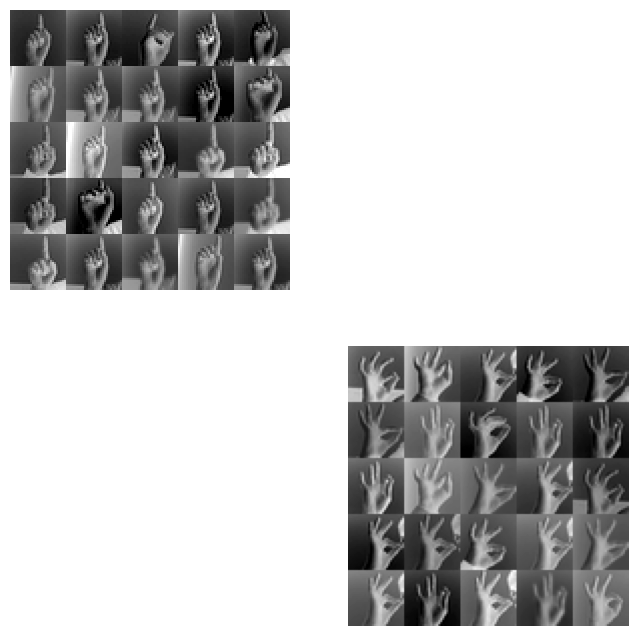

In [50]:
cl_a, cl_b = 3, 5
X_aa = x_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = x_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = x_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = x_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221)
if len(X_aa) > 0:
    plot_language_signs(X_aa[:25], images_per_row=5)
if len(X_ab) > 0:
    plt.subplot(222); plot_language_signs(X_ab[:25], images_per_row=5)
if len(X_ba) > 0:
    plt.subplot(223); plot_language_signs(X_ba[:25], images_per_row=5)
if len(X_bb) > 0:
    plt.subplot(224); plot_language_signs(X_bb[:25], images_per_row=5)
plt.show()

### Multilabel Classification

In [51]:
from sklearn.neighbors import KNeighborsClassifier

y_train_shoes = (y_train == 5) | (y_train == 7) | (y_train == 9)
y_train_tops = (y_train == 0) | (y_train == 2) | (y_train == 4) | (y_train == 6)
y_multilabel = np.c_[y_train_shoes, y_train_tops]

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)
knn_clf.predict([some_signs])

array([[False, False]])

In [52]:
y_train_knn_pred = cross_val_predict(knn_clf, x_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9868692395458227

### Multioutput Classification

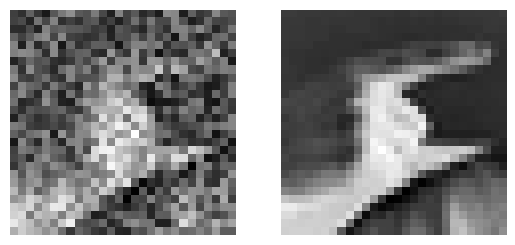

In [53]:
noise = np.random.randint(0, 100, (len(x_train), 784))
x_train_mod = x_train + noise
noise = np.random.randint(0, 100, (len(x_test), 784))
X_test_mod = x_test + noise
y_train_mod = x_train
y_test_mod = x_test
some_index = 0
plt.subplot(121); plot_signs(X_test_mod[some_index])
plt.subplot(122); plot_signs(y_test_mod[some_index])
plt.show()

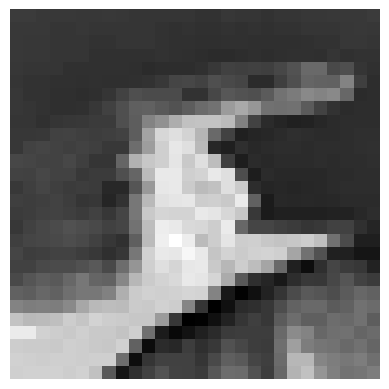

In [54]:
knn_clf.fit(x_train_mod, y_train_mod)
clean_sign = knn_clf.predict([X_test_mod[some_index]])
plot_signs(clean_sign)